# Cart-Pole Q-Learning
Notebook for experimenting with a Q-learning strategy for the cart-pole environment.

In [1]:
import gym
import itertools
import numpy as np
import pandas as pd
from numpy.random import default_rng
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

plt.style.use('seaborn-colorblind')

In [2]:
%matplotlib notebook

## Exploring the environment

In [3]:
env = gym.make('CartPole-v1')
print(env.observation_space)
print(env.action_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Discrete(2)


This shows that the state space comprises of 4 numbers:
- position of the cart in the range [-4.8, 4.8]
- velocity of the cart in the range [-inf, inf]
- angle of the pole in the range [-0.418, 0.418] (equivalent to +/- 24 deg)
- angular velocity of the pole in the range [-inf, inf].

The action space is discrete with two values -- 0 to move left, 1 to move right.

Now randomly sample action space and observe the distributions. This will allow for sensible setting of bins for the unbounded variables in the continuous state space.

In [4]:
sample_observations = {'position': [], 'velocity': [], 'angle': [], 'angular_velocity': []}

for episode in tqdm(range(1000)):
    env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        observation, _, done, _ = env.step(action)
        sample_observations['position'].append(observation[0])
        sample_observations['velocity'].append(observation[1])
        sample_observations['angle'].append(observation[2])
        sample_observations['angular_velocity'].append(observation[3])
env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


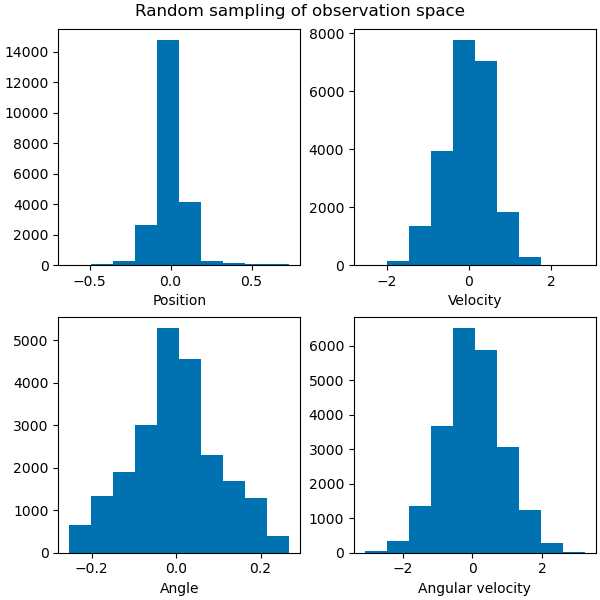

Text(0.5, 0, 'Angular velocity')

In [5]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(6, 6))
axs = axs.flat
axs[0].hist(sample_observations['position'])
axs[1].hist(sample_observations['velocity'])
axs[2].hist(sample_observations['angle'])
axs[3].hist(sample_observations['angular_velocity'])

fig.suptitle('Random sampling of observation space')
axs[0].set_xlabel('Position')
axs[1].set_xlabel('Velocity')
axs[2].set_xlabel('Angle')
axs[3].set_xlabel('Angular velocity')

The bounded state variables (position and angle) can be discretised with the same bounds. The unbounded ones may have bounds inferred from the randomly-sampled distributions. To allow the agent to meaningfully explore the state space, these bounds should at least encompass the width of the randomly-sampled distribution.

In [6]:
# # Define the number of bins for each state variable (this is actually n_bins + 1)
# n_bins = [6, 6, 6, 6]  # Position, velocity, angle, angular velocity

# # Now create the bins
# position_bins = np.linspace(env.observation_space.low[0], env.observation_space.high[0], n_bins[0])
# velocity_bins = np.linspace(-5, 5, n_bins[1])
# angle_bins = np.linspace(env.observation_space.low[2], env.observation_space.high[2], n_bins[2])
# angular_velocity_bins = np.linspace(-5, 5, n_bins[3])

## Create agent
Define a class describing the Q-learning agent and associated methods.

In [7]:
class QAgent:
    """Q-learning agent for cart-pole environment.
    
    Parameters
    ----------
    n_bins : list, optional
        Length 4 list of ints specifying the number of bins for
        discretising the state space. Order:
        position, velocity, angle, angular_velocity.
        Defaults to `[5, 5, 5, 5]`.
    lr_init, eps_init : float, optional
        Initial value of learning rate and epsilon.
        Defaults to 1.0.
    lr_min, eps_min : float, optional
        Minimum value of learning rate and epsilon.
        Defaults to 0.05.
    lr_decay, eps_decay : float, optional
        Decay factor of learning rate and epsilon.
        `lr_decay` deafults to 10, and `eps_decay` to 20.
    discount_factor : float, optional
        Defaults to 0.9.
    n_episodes : int, optional
        Number of episodes for training.
        Defaults to 500.
    progress_bars : bool, optional
        Whether to show tqdm progress bar per episode.
        Defaults to True.
    Q_table_path : str, optional
        Path to a pre-populated Q-table. No checks are performed to see if
        the table is compatible with the other parameters (namely, the values
        of `n_bins`).
        Defaults to None, which initialises a Q-table of the correct shape with
        zeros.
        
    Attributes
    ----------
    env : Gym CartPole environment
    Q_table : numpy array
        Q table. Initialised with zeros or loaded from file and updated during training.
    steps : list
        List of number of steps that the pole was kept upright corresponding
        to episode. Populated during training.
    avg_steps : float
        Average steps over training.
    learn_area : int
        Area under episodic learning curve.
    states : list
        List of states at each iteration when the agent is run. Populated during
        a call to run_agent().
    """
    def __init__(
        self,
        n_bins=[5, 5, 5, 5],
        lr_init=1.0, lr_min=0.05, lr_decay=10,
        eps_init=1.0, eps_min=0.05, eps_decay=20,
        discount_factor=0.9,
        n_episodes=500,
        progress_bars=True,
        Q_table_path=None
    ):
        self.n_bins = n_bins
        self.lr_init = lr_init
        self.lr = lr_init
        self.lr_min = lr_min
        self.lr_decay = lr_decay
        self.eps_init = eps_init
        self.eps = eps_init
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.discount_factor = discount_factor
        self.n_episodes = n_episodes
        self.progress_bars = progress_bars
        self.Q_table_path = Q_table_path
        
        self.rng = default_rng()
        self.env = gym.make('CartPole-v1')
        self.bins = self._create_bins()
        self.steps = []
        self.avg_steps = None
        self.states = None
        
        if self.Q_table_path is None:
            self.Q_table = self._initialise_Q_table()
        else:
            self.Q_table = self._load_Q_table()
        
        
    def _initialise_Q_table(self):
        """Create Q-table of correct shape filled with zeros."""
        return np.zeros(list(self.n_bins) + [self.env.action_space.n])
    
    
    def _load_Q_table(self):
        """Load pre-populated Q-table from file.
        
        File should have been created with the save_Q_table() method.
        """
        Q_table = np.load(self.Q_table_path)
        return Q_table
        
        
    def _reset(self):
        self.lr = self.lr_init
        self.eps = self.eps_init
        self.Q_table = self._initialise_Q_table()
        
    
    def _create_bins(self):
        """Create bins for discretising the state space.
        
        Returns
        -------
        bins : dict
            Dictionary where keys are the state variable names and values
            are lists of bin edges.
        """
        bins = {
            'position': np.linspace(
                self.env.observation_space.low[0],
                self.env.observation_space.high[0],
                self.n_bins[0]
            ),
            'velocity': np.linspace(-5, 5, self.n_bins[1]),
            'angle': np.linspace(
                self.env.observation_space.low[2],
                self.env.observation_space.high[2],
                self.n_bins[2]
            ),
            'angular_velocity': np.linspace(-5, 5, self.n_bins[3])
        }        
        return bins
    
    
    def _discretise_state(self, state):
        """Discretise a state by binning the values.
        
        Outliers are considered to be in the nearest edge bin.
        
        Parameters
        ----------
        state : list
            List containing observation of cart-pole state.
        
        Returns
        -------
        tuple
            4-tuple containing bin index of discretised value for each state
            variable.
        """
        # Unpack state observations
        pos_obs, vel_obs, ang_obs, ang_vel_obs = state
        
        # Discretise each one
        def discretise_observation(obs, var):
            discr_obs = np.digitize(
                np.clip(obs, self.bins[var].min(), self.bins[var].max()),
                self.bins[var]
            ) - 1
            return discr_obs
        pos_discr = discretise_observation(pos_obs, 'position')
        vel_discr = discretise_observation(vel_obs, 'velocity')
        ang_discr = discretise_observation(ang_obs, 'angle')
        ang_vel_discr = discretise_observation(ang_vel_obs, 'angular_velocity')
        
        return (pos_discr, vel_discr, ang_discr, ang_vel_discr)
    
    
    def _update_Q_table(self, old_state, new_state, action, reward):
        """Update the Q table using Q-learning algorithm.
        
        Parameters
        ----------
        old_state, new_state : tuple
            Discretised 4-tuple state descriptor.
        action : int
            Action relating `old_state` to `new_state`.
        reward : int
        
        References
        ----------
        - Watkins, C. J. C. H. "Learning from Delayed Rewards" (1989)
          https://www.academia.edu/3294050/Learning_from_delayed_rewards
        - Sutton, R. S. & Barto, A. G. "Reinforcement Learning: An Introduction"
          2nd ed. (2018). Eqn. (6.8).
        """
        self.Q_table[old_state][action] += self.lr * (reward + \
            self.discount_factor * np.max(self.Q_table[new_state]) - \
            self.Q_table[old_state][action])
        
        
    def _epsilon_greedy_action(self, state):
        """Select best guess of optimal action with probability (1 - epsilon).
        Otherwise, sample random action from space of all possible actions.
        
        Returns
        -------
        int
        """
        if self.rng.uniform() > self.eps:
            return np.argmax(self.Q_table[state])
        else:
            return self.env.action_space.sample()
        
        
    def _update_learning_rate(self, episode):
        """Update the learning rate to decay with increasing episode number."""
        new_lr = max(
            self.lr_min,
            min(self.lr_init, 1-np.log10((episode+1)/self.lr_decay))
        )
        return new_lr
        
        
    def _update_epsilon(self, episode):
        """Update the epsilon value to decay with increasing episode number."""
        new_eps = max(
            self.eps_min,
            min(self.eps_init, 1-np.log10((episode+1)/self.eps_decay))
        )
        return new_eps
    
    
    def _calculate_performance_metrics(self):
        """Calculate a couple of performance metrics.
        
        Returns
        -------
        avg_steps : float
            Average number of steps before termination.
        """
        avg_steps = np.average(self.steps)
        return avg_steps
        
        
    def train(self):
        """Train the Q-learning agent."""
        
        episode_gen = range(self.n_episodes)
        if self.progress_bars:
            episode_gen = tqdm(episode_gen)
        
        for episode in episode_gen:
            step = 0
            state = self._discretise_state(self.env.reset())
            done = False
            while not done:
                step += 1
                action = self._epsilon_greedy_action(state)
                new_state, reward, done, _ = self.env.step(action)
                new_state = self._discretise_state(new_state)
                self._update_Q_table(state, new_state, action, reward)
                state = new_state
            
            # Record how well this episode went
            self.steps.append(step)
            
            # Update learning rate and epsilon
            self.lr = self._update_learning_rate(episode)
            self.eps = self._update_epsilon(episode)
        
        self.env.close()
        
        # Performance metrics
        self.avg_steps = self._calculate_performance_metrics()
        
        
    def save_Q_table(self, path):
        """Save a copy of the current Q-table.
        
        Parameters
        ----------
        path : str
            Path to file to save the Q-table to.
        """
        np.save(path, self.Q_table)
        
        
    def plot_lr_eps(self,
                    ax=None,
                    ax_labels=True,
                    legend=True,
                    grid=True,
                    lr_plot_kwargs={'label': 'Learning rate', 'c': 'C0', 'ls': '-'},
                    eps_plot_kwargs={'label': 'Epsilon', 'c': 'C1', 'ls': '--'}):
        """Plot learning rate and epsilon as a function of episode number."""
        lr_plot = [self.lr_init]
        eps_plot = [self.eps_init]
        for e in range(1, self.n_episodes):
            lr_plot.append(self._update_learning_rate(e))
            eps_plot.append(self._update_epsilon(e))
        
        if ax is None:
            fig, ax = plt.subplots(constrained_layout=True)
        ax.plot(lr_plot, **lr_plot_kwargs)
        ax.plot(eps_plot, **eps_plot_kwargs)
        if ax_labels:
            ax.set_xlabel('Episode')
            ax.set_ylabel(r'LR or $\epsilon$')
        if legend:
            ax.legend()
        if grid:
            ax.grid()
        ax.set_xlim(0, self.n_episodes)
        ax.set_ylim(0, max(self.lr_init, self.eps_init))
        
        
    def plot_progress(self, ax=None, ax_labels=True, grid=True, plot_kwargs={}):
        """Plot the learning progress of the agent."""
        if ax is None:
            fig, ax = plt.subplots()
        ax.plot(self.steps, **plot_kwargs)
        if ax_labels:
            ax.set_xlabel('Episode')
            ax.set_ylabel('Steps')
        if grid:
            ax.grid()
        ax.set_xlim(0, self.n_episodes)
        ax.set_ylim(0, 500)
        
        
    def run_agent(self, render=True):
        """Run the agent with the current Q-table and no stochasticity
        in the action sampling.
        
        Parameters
        ----------
        render : bool, optional
            Defaults to True.
        """
        state = self._discretise_state(self.env.reset())
        state_discr = self._discretise_state(state)
        done = False
        self.states = [state]
        while not done:
            if render:
                self.env.render()
            action = np.argmax(self.Q_table[state_discr])
            state, reward, done, _ = self.env.step(action)
            self.states.append(state)
            state_discr = self._discretise_state(state)

  0%|          | 0/500 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


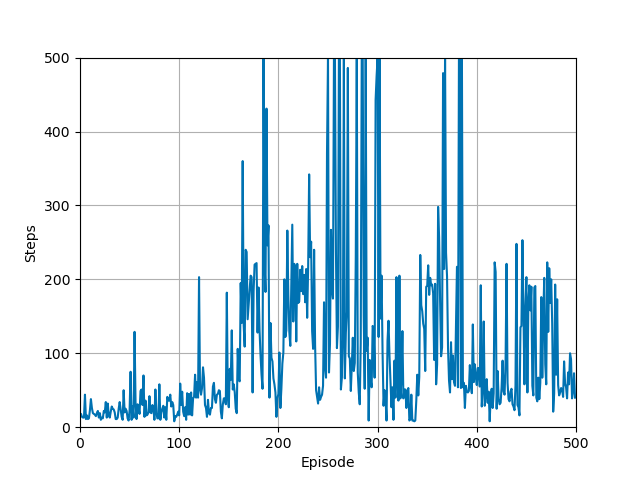

<IPython.core.display.Javascript object>


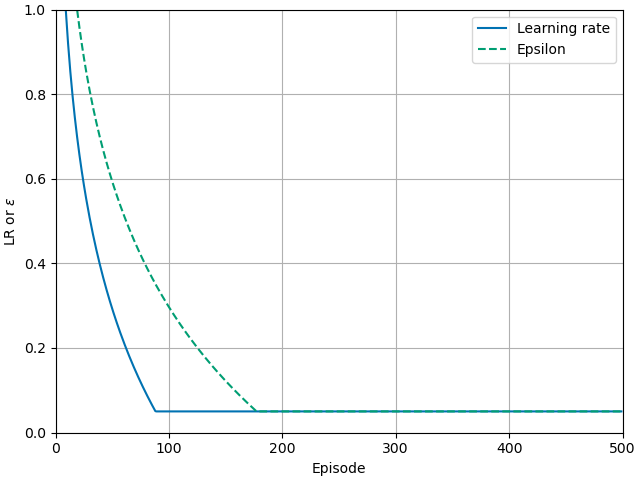

In [8]:
test_agent = QAgent()
test_agent.train()
test_agent.plot_progress()
test_agent.plot_lr_eps()
test_agent.run_agent(render=False)
test_agent.env.close()
test_agent.save_Q_table('./Q-tables/test.npy')

## Tune hyperparameters
To tune hyperparameters, we need a metric of performance for the agent. Start with average steps achieved per episode, `avg_steps`.

### Initial grid search
Start with a simple grid search of learning rate decay and epsilon decay. Train 5 agents with each hyperparameter pair and take the average.

<IPython.core.display.Javascript object>


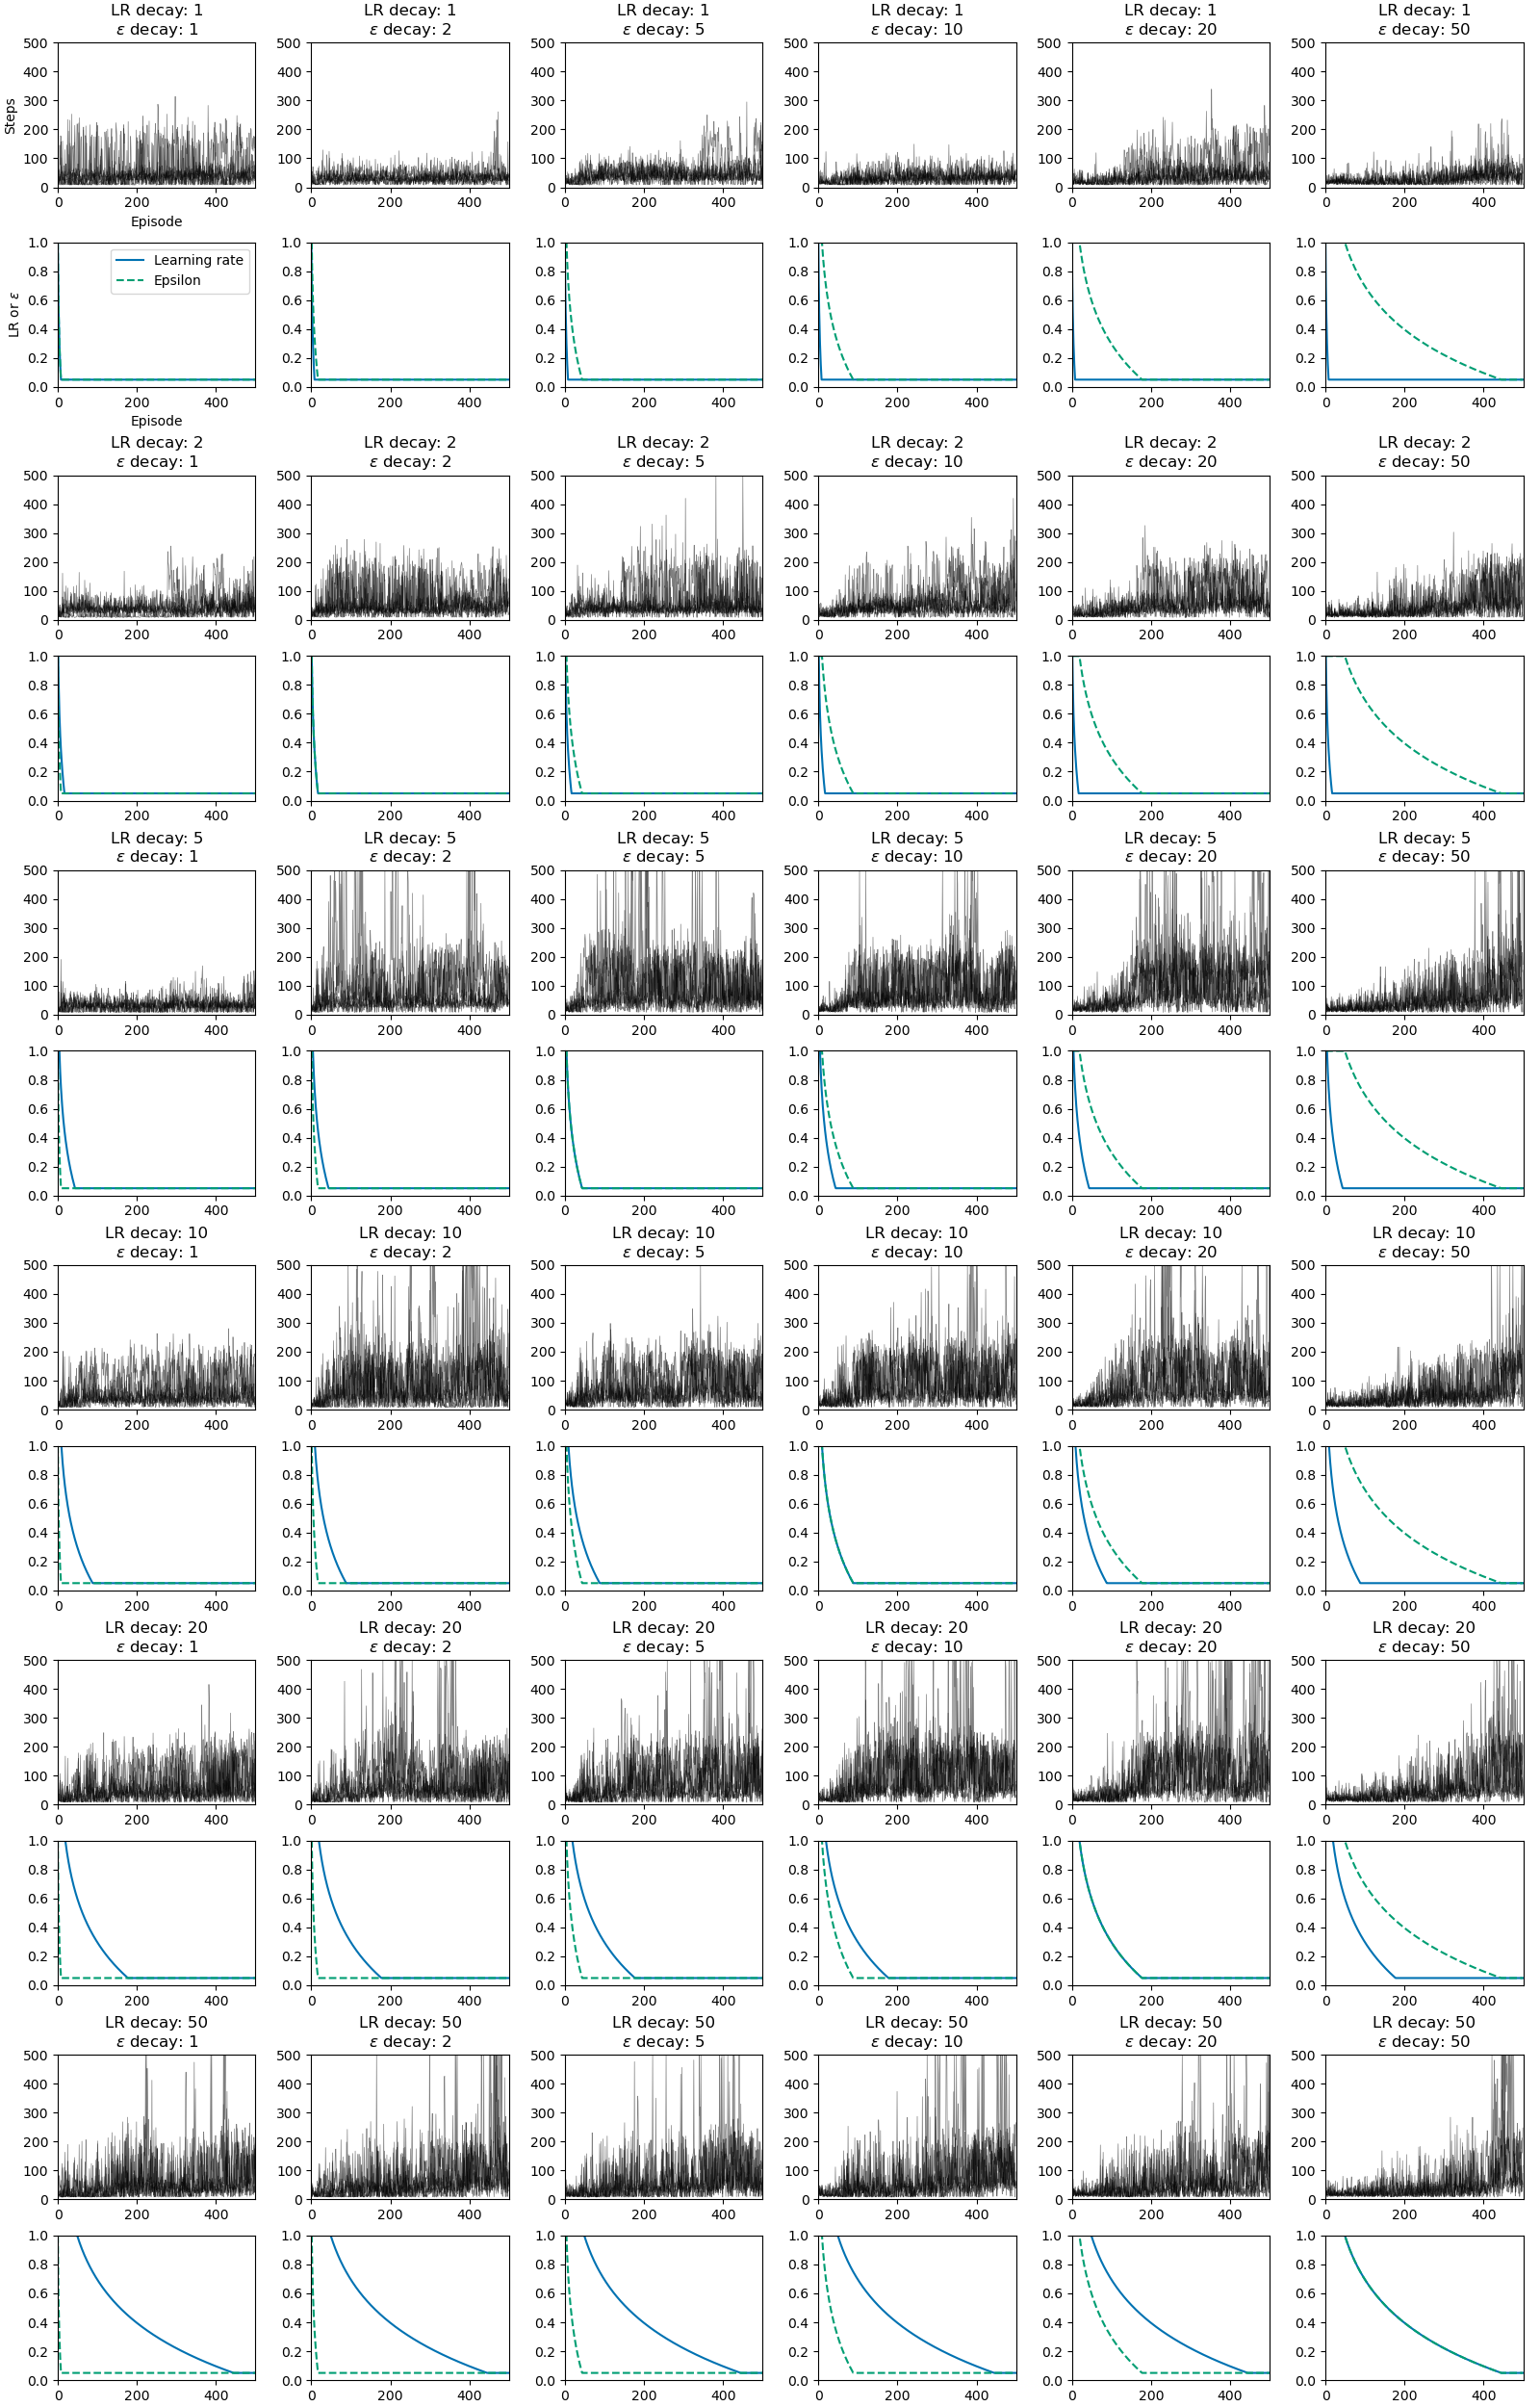

  0%|          | 0/36 [00:00<?, ?it/s]

In [9]:
param_grid = {'lr_decay': [1, 2, 5, 10, 20, 50], 'eps_decay': [1, 2, 5, 10, 20, 50]}
param_list = list(itertools.product(*[param_grid[key] for key in param_grid.keys()]))

fig = plt.figure(figsize=(16, 25), constrained_layout=True)
gs = fig.add_gridspec(ncols=len(param_grid['lr_decay']), nrows=2*(len(param_grid['eps_decay'])))
rows_list = []
for i, param_pair in tqdm(enumerate(param_list), total=len(param_list)):
    ax_ind = np.unravel_index(i, (len(param_grid['eps_decay']), len(param_grid['lr_decay'])))
    ax_ind = list(ax_ind)
    ax_ind_step = ax_ind.copy()
    ax_ind_decay = ax_ind.copy()
    ax_ind_step[0] *= 2
    ax_ind_decay[0] = 2 * ax_ind_decay[0] + 1
    ax_ind_step = tuple(ax_ind_step)
    ax_ind_decay = tuple(ax_ind_decay)
    ax_step = fig.add_subplot(gs[ax_ind_step])
    ax_decay = fig.add_subplot(gs[ax_ind_decay])
    ax_step.set_title(f'LR decay: {param_pair[0]}\n' + fr'$\epsilon$ decay: {param_pair[1]}')
    
    avg_steps_temp = 0
    for _ in range(5):
        agent = QAgent(lr_decay=param_pair[0], eps_decay=param_pair[1], progress_bars=False)
        agent.train()
        avg_steps_temp += agent.avg_steps
        
        if i != 0:
            ax_labels = False
            legend = False
        else:
            ax_labels = True
            legend = True
            
        ax_decay.plot()
        agent.plot_progress(
            ax=ax_step, ax_labels=ax_labels, grid=False,
            plot_kwargs={'c': 'k', 'alpha': 0.5, 'lw': 0.5}
        )
            
    agent.plot_lr_eps(
        ax=ax_decay, ax_labels=ax_labels, legend=legend, grid=False,        
    )
        
    rows_list.append({
        'lr_decay': param_pair[0],
        'eps_decay': param_pair[1],
        'avg_steps': avg_steps_temp/5
    })
    
df_param_grid = pd.DataFrame(rows_list)

<IPython.core.display.Javascript object>


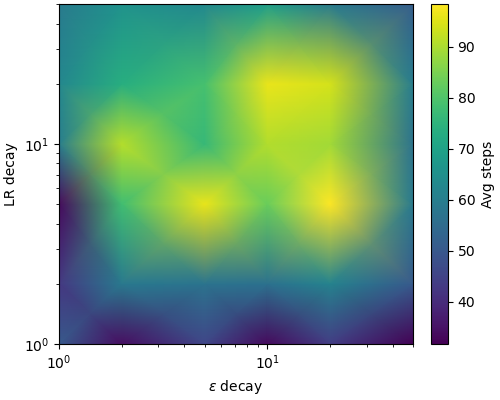

In [10]:
# Plot a heatmap of average steps vs learning rate decay and epsilon decay

def plot_heatmap(ax, metric):
    df_new = df_param_grid.pivot(index='lr_decay', columns='eps_decay', values=metric)
    hm = ax.pcolormesh(df_new.columns, df_new.index, df_new.values, shading='gouraud')
    return hm

fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
hm = plot_heatmap(ax, 'avg_steps')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\epsilon$ decay')
ax.set_ylabel('LR decay')
cb = fig.colorbar(hm, ax=ax)
cb.set_label('Avg steps')

Values of learning rate decay and epsilon decay are clearly important and optimisable.

### Effect of random seed
Before doing an large hyperparameter search, look at the effect of the random seed on agent training and performance. 

The following creates 50 agents and trains them over a large number of episodes with slow decay of epsilon and learning rate. The final 1/3 of episodes of each agent's training is with zero learning rate and zero epsilon (i.e. the learned policy is simply enacted) to see how the agent performs.

<IPython.core.display.Javascript object>


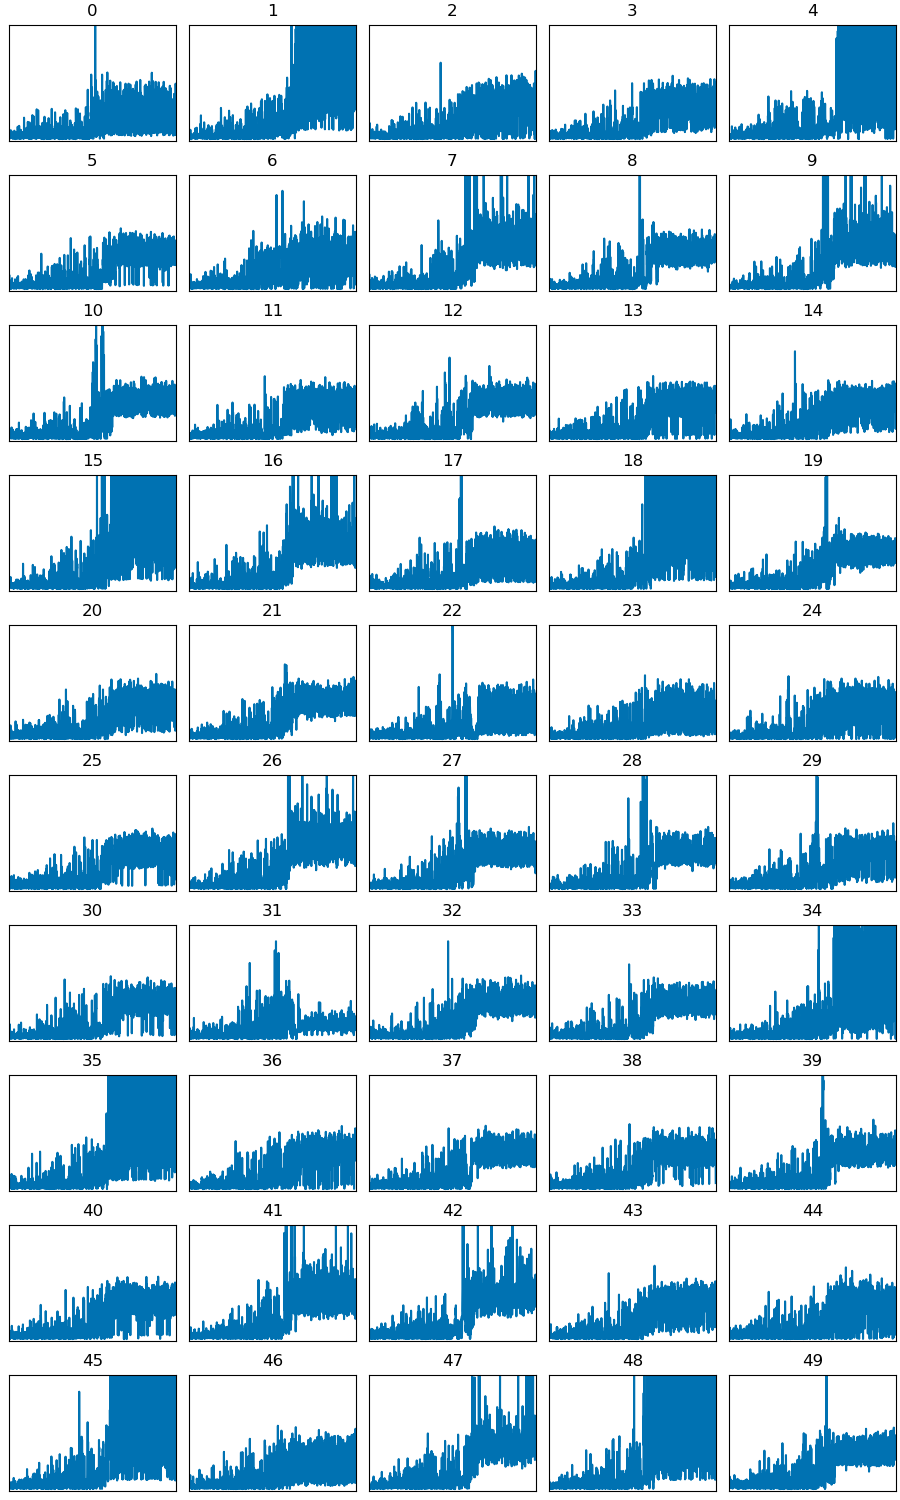

  0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
n_agents = 50

agents = []
fig = plt.figure(figsize=(9, 15), constrained_layout=True)
gs = fig.add_gridspec(ncols=5, nrows=10)
for i in tqdm(range(n_agents)):
    ax = fig.add_subplot(gs[np.unravel_index(i, (10, 5))])
    ax.set_xlim(0, 1500)
    ax.set_ylim(0, 500)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{i}')
    agent_temp = QAgent(
        n_episodes=1500, lr_decay=100, eps_decay=100, lr_min=0, eps_min=0, progress_bars=False
    )
    agent_temp.train()
    agent_temp.plot_progress(ax=ax, ax_labels=False, grid=False)
    agents.append(agent_temp)

Broadly, we can identify three types of policies. Firstly, there are those that don't really learn anything useful:
![Bad progress](images/bad_progress.png)

There are also those that learn a reasonable (although unstable) policy for keeping the pole upright:
![Good progress](images/good_progress.png)
![Good progress gif](videos/good_agent_example.gif)

And finally, there are these peculiar agents:
![Yeet progress](images/yeet_progress.png)

The latter deserve closer inspection. If we render the case where the agent enacts such a policy, we consistently see the following behaviour:
![Yeet video](videos/yeet_agent_example.gif)

Now let's look at the evolution of the state for an agent enacting this kind of policy and compare it to ones enacting 'good' and random policies.

Note: The following commented-out code was used to generate the Q-tables that are then loaded in the next cell. If the notebook is re-run, the indices defining the agents of interest will most likely have to be redefined.

In [53]:
# agent_runaway = 8  # Instance that looks like it accelerated to the boundary
# agent_good = 1  # Good instance
# agent_rand = QAgent(eps_init=1)

# agents[agent_runaway].save_Q_table('./Q-tables/runaway.npy')
# agents[agent_good].save_Q_table('./Q-tables/good.npy')
# agent_rand.save_Q_table('./Q-tables/random.npy')

<IPython.core.display.Javascript object>


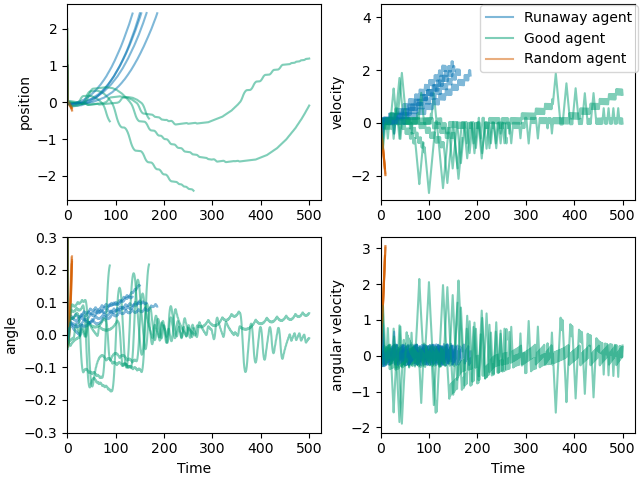

In [13]:
agent_runaway = QAgent(Q_table_path='./Q-tables/runaway.npy')
agent_good = QAgent(Q_table_path='./Q-tables/good.npy')
agent_rand = QAgent(Q_table_path='./Q-tables/random.npy')

fig, axs = plt.subplots(2, 2, constrained_layout=True)
axs = axs.flat
for i in range(5):
    agent_runaway.run_agent(render=False)
    agent_good.run_agent(render=False)
    agent_rand.run_agent(render=False)
    for ii in range(4):
        pl1, = axs[ii].plot(
            np.array(agent_runaway.states)[:, ii],
            c='C0', alpha=0.5
        )
        pl2, = axs[ii].plot(
            np.array(agent_good.states)[:, ii],
            c='C1', alpha=0.5
        )
        pl3, = axs[ii].plot(
            np.array(agent_rand.states)[:,ii],
            c='C2', alpha=0.5
        )

variables = ['position', 'velocity', 'angle', 'angular velocity']
for i in range(4):
    axs[i].set_ylabel(f'{variables[i]}')
    axs[i].set_xlim(0, None)
axs[2].set_ylim(-0.3, 0.3)
axs[2].set_xlabel('Time')
axs[3].set_xlabel('Time')
axs[1].set_ylim(None, 4.5)

pl1.set_label('Runaway agent')
pl2.set_label('Good agent')
pl3.set_label('Random agent')
fig.legend(loc=(0.75, 0.85))

The runaway agent has learned that it can slightly perturb the cart at the start of the episode so that the pole is angled slightly to the left, and then accelerate to the left to balance out the gravitational force on the pole. Sure, the maximum reward achievable by this policy is around 200 (much less than the 500 up for grabs and sometimes achieved by the good agent) as the episode ends when the cart reaches the boundary. However, this policy is more stable (there is less variance in number of steps per episode) and easier to learn than one that can keep the pole upright. With the decaying learning rate and epsilon, the agent gets stuck in this local minimum of the policy space.

This is the result of two well-known concepts in RL:
- "Exploration/exploitation trade-off". The decaying epsilon does not afford the agent enough power (through randomness) in its exploration to discover potentially better policies (like keeping the pole upright and the cart within the frame).
- "Credit assignment problem". The goal has been set such that the agent can achieve a reasonably high reward by enacting a relatively simple policy that is not actually desirable.